# Лабораторная работа №1 (Шведский язык)


## Задача I. Создание PoS-теггера


Необходимо создать PoS-теггер для языков, соответствующих вашему варианту.

В данной лабораторной работе будут использоваться корпуса языков из проекта Universal Dependencies http://universaldependencies.org/

### Список задач:

* **Привести типологию языков Вашего варианта**

**Шведский** - язык северногерманской (скандинавской) подгруппы германской группы индоевропейской семьи. Письменность на основе латинского алфавита. Язык в большой степени **аналитического строя**. Имеются два рода — *общий* (объединивший мужской и женский; в некоторых диалектах шведского они сохраняются до сих пор) и *средний* — и отсутствуют падежи (в древнешведском существовали именительный, родительный, винительный и дательный падежи). 

Артикль является показателем рода, числа, а также определённости и неопределённости слова в контексте. Неопределённый артикль, который ставится перед существительным, для общего рода — **en**, а для среднего рода — **ett**, например: en flicka («девочка»), en dag («день»), ett hus (дом), ett regn («дождь»). Определённый, также известен как «постпозитивный артикль», в шведском языке используется по традиционной для скандинавских языков схеме, которая отличается от большинства других европейских языков (однако имеет аналоги в балканских языках). Он присоединяется к концу слова как суффикс. Это происходит по следующей схеме: существительное + -en / -et.


* **Считать файлы, соответствующие вашим языкам**

In [1]:
from conllu import parse, parse_tree
from collections import Counter
import numpy as np


import matplotlib.pyplot as plt
from keras.layers import SimpleRNN
from keras.layers.core import Activation, Dense, RepeatVector
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU, LSTM
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.metrics import top_k_categorical_accuracy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
sv_train = 'sv_lines-ud-train.conllu'
sv_test = 'sv_lines-ud-test.conllu'       

In [3]:
def parse_file(file):
    file = open(file, 'r', encoding='utf-8')      #Считываем файл
    data = file.read()
    file.close()
    
    sents_word = []                               #Создаем пустой список для записи словоформ
    w_freqs = Counter()                           #Создаем словарь типа Counter для подсчета частот словоформ
    
    sents_pos = []                                #Создаем пустой список для записи POS тегов
    pos_freqs = Counter()                         #Создаем пустой словарь типа Counter для подсчета частот тегов

    for cur_sentence in parse(data):               #Проходим по каждому предложению в файле
        cur_sentence_words = [] 
        cur_sentence_pos = []        
        for separated_parsed_words in cur_sentence:   #Проходим по каждому слову в текущем предложении
            cur_sentence_words.append(separated_parsed_words['form'])     #Записываем словоформы в список для текущего предложения
            w_freqs[separated_parsed_words['form']] += 1       #считаем частоту
            cur_sentence_pos.append(separated_parsed_words['upostag'])  #Записываем POS теги текущего предложения
            pos_freqs[separated_parsed_words['upostag']] += 1           #подсчитываем их частоту
        
        sents_word.append(cur_sentence_words)                   #записываем данные из списков для текущего предложения в глобальную переменную
        sents_pos.append(cur_sentence_pos)

    return (sents_word, w_freqs,
           sents_pos, pos_freqs)


Считываем из всех файлов и сохраняем список словоформ (sents_word), их частоты(w_freqs), POS-теги (sents_pos) и частоту POS-тегов (pos_freqs) для каждого 

In [4]:
sv_sents_word, sv_w_freqs, sv_sents_pos, sv_pos_freqs = parse_file(sv_train)
svtest_sents_word, svtest_w_freqs, svtest_sents_pos, svtest_pos_freqs = parse_file(sv_test)


* **Привести дескриптивную статистику для тренировочной и тестовой выборки**

a. Число предложений / уникальных словоформ;

b. Число уникальных PoS-тегов;

c. Максимальное и минимальное число слов в предложении;

d. Математическое ожидание и медиана числа слов в предложении;

e. Доля новых (не встречавшихся в тренировочной выборке) слов в тестовой выборке


In [5]:
print("Дескриптивная статистика для шведского языка: ")

svtrain_length_of_sentences_list = np.array([len(cur_sentence) for cur_sentence in sv_sents_word])
svtest_length_of_sentences_list = np.array([len(cur_sentence) for cur_sentence in svtest_sents_word])

print("Тренировочная выборка: \n\tЧисло предложений: {} \n\tЧисло уникальных словоформ: {}".format(len(sv_sents_word), len(sv_w_freqs)))
print("\tЧисло уникальных PoS-тегов: {}".format(len(sv_pos_freqs)))
print("\tМаксимальное число слов в предложении: {}".format(np.max(svtrain_length_of_sentences_list)))
print("\tМинимальное число слов в предложении: {}".format(np.min(svtrain_length_of_sentences_list)))
print("\tМатематическое ожидание числа слов в предложении: {}".format(np.mean(svtrain_length_of_sentences_list)))
print("\tМедиана числа слов в предложении: {}".format(np.median(svtrain_length_of_sentences_list)))
print("\tДоля новых слов в тестовой выборке: {}".format(len(set(svtrain_length_of_sentences_list)&set(svtest_length_of_sentences_list))/ 
len(set(svtrain_length_of_sentences_list))*100))

Дескриптивная статистика для шведского языка: 
Тренировочная выборка: 
	Число предложений: 2738 
	Число уникальных словоформ: 9658
	Число уникальных PoS-тегов: 17
	Максимальное число слов в предложении: 93
	Минимальное число слов в предложении: 1
	Математическое ожидание числа слов в предложении: 17.64791818845873
	Медиана числа слов в предложении: 15.0
	Доля новых слов в тестовой выборке: 77.02702702702703


* **На основании полученной статистики задать параметры:**

MAX_SEQLEN (максимальная длина последовательности)

S_MAX_FEATURES  (максимальное количество атрибутов)

T_MAX_FEATURES  (максимальное количество тегов)


In [6]:
MAX_SEQLEN = 20      #Хотя максимальное число слов в предложении равно 93 следует учесть также медиану числа слов в предложении (14).
S_MAX_FEATURES = 9658  #Количество уникальных словоформ
T_MAX_FEATURES = 17    #Количество уникальных PoS-тегов

* **Задайте число эпох и количество итераций**

In [21]:
EMBED_SIZE = 300
HIDDEN_SIZE = 100

BATCH_SIZE = 64



Метки словоформ:
* PAD - для заполнения (характеризует пустоту), когда размер предложения меньше, чем MAX_SEQLEN
* UNK - для неизвестных словоформ.

Для иллюстрации PoS-теггера нужно составить таблицы:

Составляем таблицу поиска для словоформ:

In [22]:
s_vocabsize = min(len(sv_w_freqs), S_MAX_FEATURES) + 2
s_word2index = {x[0]:i+2 for i, x in 
    enumerate(sv_w_freqs.most_common(S_MAX_FEATURES))}
s_word2index["PAD"] = 0 # Для заполнения, когда размер предлложения меньше, чем MAX_SEQ
s_word2index["UNK"] = 1 # Для неизвестных словоформ, которые могут встретиться
s_index2word = {v:k for k, v in s_word2index.items()}

для PoS-тегов элемент UNK не нужен, поскольку список частей речи уже известен

In [23]:
t_vocabsize = min(len(sv_pos_freqs), T_MAX_FEATURES) + 1
t_word2index = {x[0]:i+1 for i, x in 
    enumerate(sv_pos_freqs.most_common(T_MAX_FEATURES))}

t_word2index["PAD"] = 0
t_index2word = {v:k for k, v in t_word2index.items()}

Составляем целевую нейронную сеть, которая и будет выполнять частеречную разметку.

Коротко об архитектуре нейронной сети:
Как и в других задачах, считаем, что входом в нейросеть является трехмерный тензор, элементами которого являются индексы слов, длины MAX_SEQLEN;

Это проходит через слой погружения (Embedding), которому явно указывается размер словаря и размерность погружения, поэтому результат прохождения входного тензора через слой погружения будет тензор сл. формата:
(None, MAX_SEQLEN, EMBED_SIZE);

Далее этот тензор передается encoder'у - представляющий собой слой рекуррентной нейронной сети с размером выхода HIDDEN_SIZE. LSTM настроен на возврат единственного контекстного вектора (return_sequences=False - по умолчанию) после обработки последовательности длины MAX_SEQLEN, поэтому тензор LSTM слоя имеет форму (None, HIDDEN_SIZE).

Этот контекстный вектор далее реплицируется слоем 
    RepeatVector
в тензор формы (None, MAX_SEQLEN, t_vocab_size). В качестве функции активации в плотном слое используется softmax.


* **Построить четыре модели нейронной сети:**
    * SimpleRNN
    * LSTM
    * Bidirectional
    * GRU

In [24]:
num_train_samples = len(sv_sents_word) // BATCH_SIZE
num_test_samples = len(svtest_sents_word) // BATCH_SIZE

print("\tV of train samples: {}".format(num_train_samples))
print("\tV of test samples: {}".format(num_test_samples))

def get_or_else(dictionary, key, default_value):
    try:
        return dictionary[key]
    except KeyError:
        return default_value

def generate_batch(
    s_sents,  # sentences_train
    s_word2index, # word to index dictionary
    t_sents, # 
    t_word2index, 
    batch_size, 
    maxlen
):
    while True:
        # shuffle the input
        indices = np.random.permutation(np.arange(len(s_sents)))
        ss_sents = [s_sents[ix] for ix in indices]
        ts_sents = [t_sents[ix] for ix in indices]
        # convert to word indices
        si_sents = [[get_or_else(s_word2index, word, s_word2index["UNK"]) 
                    for word in sent] 
                    for sent in ss_sents]
        ti_sents = [[t_word2index[word] for word in sent]
                    for sent in ts_sents]
        # inner loop should run for an epoch
        num_batches = len(s_sents) // batch_size
        for i in range(num_batches):
            s_batch = si_sents[i * batch_size : (i + 1) * batch_size]
            t_batch = ti_sents[i * batch_size : (i + 1) * batch_size]
            sp_batch = sequence.pad_sequences(s_batch, maxlen=maxlen)
            tp_batch = sequence.pad_sequences(t_batch, maxlen=maxlen)
            tpc_batch = np_utils.to_categorical(tp_batch.reshape(-1, 1), 
                num_classes=len(t_word2index)).reshape(batch_size, 
                -1, len(t_word2index))
            yield sp_batch, tpc_batch

	V of train samples: 42
	V of test samples: 14


## SimpleRNN

In [25]:
NUM_EPOCHS = 15
NUM_ITERATIONS = 7

In [26]:
from keras.models import Sequential
from keras.layers import Activation, SimpleRNN
def build_pos_tagger_SimpleRNN():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(SimpleRNN(HIDDEN_SIZE))
    model.add(RepeatVector(MAX_SEQLEN))
    
    model.add(SimpleRNN(HIDDEN_SIZE, return_sequences=True))
    model.add(TimeDistributed(Dense(t_vocabsize)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

In [27]:
train_gen = generate_batch(sv_sents_word, s_word2index, sv_sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(svtest_sents_word, s_word2index, svtest_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)

In [28]:
sv_sents_word, sv_w_freqs, sv_sents_pos, sv_pos_freqs = parse_file(sv_train)
svtest_sents_word, svtest_w_freqs, svtest_sents_pos, svtest_pos_freqs = parse_file(sv_test)


In [29]:
hist_acc, hist_val_acc, hist_loss, hist_val_loss = [], [], [], []

In [30]:
SimpleRNN_POS_TAGGER = build_pos_tagger_SimpleRNN()

In [31]:
for i in range(NUM_ITERATIONS):    
    history = SimpleRNN_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc.extend(history.history["acc"])
    hist_val_acc.extend(history.history["val_acc"])
    hist_loss.extend(history.history["loss"])
    hist_val_loss.extend(history.history["val_loss"])
    
    # Проиллюстрируем некоторые примеры разметки
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = SimpleRNN_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)

Epoch 1/15
42/42 [==============================] - 7s 157ms/step - loss: 2.0198 - acc: 0.3738 - val_loss: 1.7198 - val_acc: 0.4359
Epoch 2/15
42/42 [==============================] - 5s 114ms/step - loss: 1.7629 - acc: 0.4181 - val_loss: 1.6861 - val_acc: 0.4371
Epoch 3/15
42/42 [==============================] - 5s 114ms/step - loss: 1.6680 - acc: 0.4396 - val_loss: 1.6839 - val_acc: 0.4421
Epoch 4/15
42/42 [==============================] - 5s 114ms/step - loss: 1.6061 - acc: 0.4521 - val_loss: 1.6278 - val_acc: 0.4551
Epoch 5/15
42/42 [==============================] - 5s 114ms/step - loss: 1.5420 - acc: 0.4712 - val_loss: 1.6040 - val_acc: 0.4674
Epoch 6/15
42/42 [==============================] - 5s 115ms/step - loss: 1.4908 - acc: 0.4827 - val_loss: 1.5811 - val_acc: 0.4734
Epoch 7/15
42/42 [==============================] - 5s 114ms/step - loss: 1.4430 - acc: 0.4969 - val_loss: 1.5868 - val_acc: 0.4768
Epoch 8/15
42/42 [==============================] - 5s 114ms/step - loss: 1.

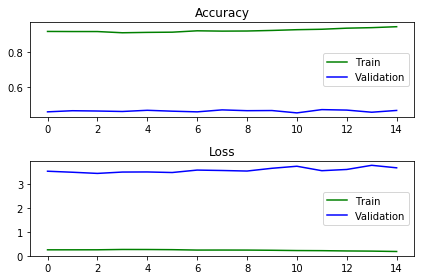

In [32]:
# plot loss and accuracy
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

При 9 итерациях по 10 эпох переобучение началось на 8 итерации

## GRU

In [33]:
NUM_EPOCHS = 10
NUM_ITERATIONS = 8

In [34]:
def build_pos_tagger_GRU():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(GRU(HIDDEN_SIZE))
    model.add(RepeatVector(MAX_SEQLEN))
    
    model.add(GRU(HIDDEN_SIZE, return_sequences=True))
    model.add(TimeDistributed(Dense(t_vocabsize)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

In [35]:
train_gen = generate_batch(sv_sents_word, s_word2index, sv_sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(svtest_sents_word, s_word2index, svtest_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)

In [36]:
sv_sents_word, sv_w_freqs, sv_sents_pos, sv_pos_freqs = parse_file(sv_train)
svtest_sents_word, svtest_w_freqs, svtest_sents_pos, svtest_pos_freqs = parse_file(sv_test)


In [37]:
hist_acc, hist_val_acc, hist_loss, hist_val_loss = [], [], [], []

In [38]:
GRU_POS_TAGGER = build_pos_tagger_GRU()

In [39]:
for i in range(NUM_ITERATIONS):    
    history = GRU_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc.extend(history.history["acc"])
    hist_val_acc.extend(history.history["val_acc"])
    hist_loss.extend(history.history["loss"])
    hist_val_loss.extend(history.history["val_loss"])
    
    # Проиллюстрируем некоторые примеры разметки
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = GRU_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)

Epoch 1/10
42/42 [==============================] - 13s 301ms/step - loss: 2.3553 - acc: 0.3087 - val_loss: 1.8757 - val_acc: 0.3925
Epoch 2/10
42/42 [==============================] - 9s 219ms/step - loss: 1.8143 - acc: 0.4038 - val_loss: 1.7182 - val_acc: 0.4323
Epoch 3/10
42/42 [==============================] - 9s 208ms/step - loss: 1.7405 - acc: 0.4234 - val_loss: 1.6797 - val_acc: 0.4375
Epoch 4/10
42/42 [==============================] - 9s 212ms/step - loss: 1.7110 - acc: 0.4336 - val_loss: 1.6563 - val_acc: 0.4580
Epoch 5/10
42/42 [==============================] - 9s 209ms/step - loss: 1.6867 - acc: 0.4406 - val_loss: 1.6441 - val_acc: 0.4575
Epoch 6/10
42/42 [==============================] - 9s 211ms/step - loss: 1.6552 - acc: 0.4453 - val_loss: 1.6067 - val_acc: 0.4665
Epoch 7/10
42/42 [==============================] - 9s 222ms/step - loss: 1.6362 - acc: 0.4512 - val_loss: 1.5891 - val_acc: 0.4614
Epoch 8/10
42/42 [==============================] - 10s 228ms/step - loss: 

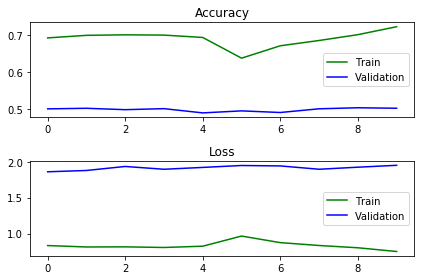

In [40]:
# plot loss and accuracy
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

При 8 итерациях по 10 эпох переобучение не началось (возможно появилось бы при большем количестве итераций)

## LSTM

In [58]:
EMBED_SIZE = 200
NUM_EPOCHS = 10
NUM_ITERATIONS = 10

In [59]:
def build_pos_tagger_LSTM():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(LSTM(HIDDEN_SIZE))
    model.add(RepeatVector(MAX_SEQLEN))
    
    model.add(LSTM(HIDDEN_SIZE, return_sequences=True))
    model.add(TimeDistributed(Dense(t_vocabsize)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

In [60]:
train_gen = generate_batch(sv_sents_word, s_word2index, sv_sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(svtest_sents_word, s_word2index, svtest_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)

In [61]:
sv_sents_word, sv_w_freqs, sv_sents_pos, sv_pos_freqs = parse_file(sv_train)
svtest_sents_word, svtest_w_freqs, svtest_sents_pos, svtest_pos_freqs = parse_file(sv_test)

In [62]:
LSTM_POS_TAGGER = build_pos_tagger_LSTM()

In [63]:
hist_acc, hist_val_acc, hist_loss, hist_val_loss = [], [], [], []


In [66]:
for i in range(NUM_ITERATIONS):    
    history = LSTM_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc.extend(history.history["acc"])
    hist_val_acc.extend(history.history["val_acc"])
    hist_loss.extend(history.history["loss"])
    hist_val_loss.extend(history.history["val_loss"])
    
    # Проиллюстрируем некоторые примеры разметки
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = LSTM_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)

Epoch 1/10
42/42 [==============================] - 23s 537ms/step - loss: 0.4532 - acc: 0.8485 - val_loss: 2.2187 - val_acc: 0.5172
Epoch 2/10
42/42 [==============================] - 15s 356ms/step - loss: 0.4585 - acc: 0.8423 - val_loss: 2.2426 - val_acc: 0.5211
Epoch 3/10
42/42 [==============================] - 14s 333ms/step - loss: 0.4835 - acc: 0.8317 - val_loss: 2.2288 - val_acc: 0.5185
Epoch 4/10
42/42 [==============================] - 14s 330ms/step - loss: 0.4706 - acc: 0.8354 - val_loss: 2.2360 - val_acc: 0.5164
Epoch 5/10
42/42 [==============================] - 14s 334ms/step - loss: 0.4971 - acc: 0.8224 - val_loss: 2.2244 - val_acc: 0.5219
Epoch 6/10
42/42 [==============================] - 14s 331ms/step - loss: 0.4930 - acc: 0.8241 - val_loss: 2.2487 - val_acc: 0.5159
Epoch 7/10
42/42 [==============================] - 14s 335ms/step - loss: 0.4770 - acc: 0.8316 - val_loss: 2.2268 - val_acc: 0.5232
Epoch 8/10
42/42 [==============================] - 14s 343ms/step - 

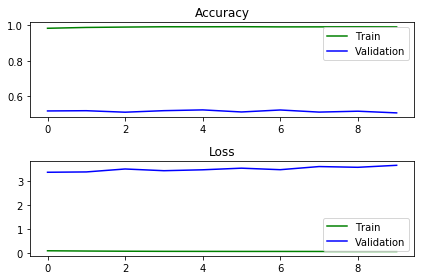

In [67]:
# plot loss and accuracy
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Bidirectional LSTM

In [68]:
NUM_EPOCHS = 10
NUM_ITERATIONS = 8

In [69]:
def build_pos_tagger_Bidirectional():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(Bidirectional(LSTM(HIDDEN_SIZE))) 
    model.add(RepeatVector(MAX_SEQLEN)) 
    model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True))) 
    model.add(TimeDistributed(Dense(t_vocabsize))) 
    model.add(Activation("softmax")) 
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

In [70]:
train_gen = generate_batch(sv_sents_word, s_word2index, sv_sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(svtest_sents_word, s_word2index, svtest_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)

In [71]:
sv_sents_word, sv_w_freqs, sv_sents_pos, sv_pos_freqs = parse_file(sv_train)
svtest_sents_word, svtest_w_freqs, svtest_sents_pos, svtest_pos_freqs = parse_file(sv_test)

In [72]:
hist_acc, hist_val_acc, hist_loss, hist_val_loss = [], [], [], []

In [73]:
Bidirectional_POS_TAGGER = build_pos_tagger_Bidirectional()

In [74]:
for i in range(NUM_ITERATIONS):    
    history = Bidirectional_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc.extend(history.history["acc"])
    hist_val_acc.extend(history.history["val_acc"])
    hist_loss.extend(history.history["loss"])
    hist_val_loss.extend(history.history["val_loss"])
    
    
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = Bidirectional_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)

Epoch 1/10
42/42 [==============================] - 51s 1s/step - loss: 2.1684 - acc: 0.3544 - val_loss: 1.7481 - val_acc: 0.4469
Epoch 2/10
42/42 [==============================] - 39s 918ms/step - loss: 1.7288 - acc: 0.4323 - val_loss: 1.6487 - val_acc: 0.4450
Epoch 3/10
42/42 [==============================] - 38s 915ms/step - loss: 1.6717 - acc: 0.4391 - val_loss: 1.6060 - val_acc: 0.4542
Epoch 4/10
42/42 [==============================] - 38s 915ms/step - loss: 1.6280 - acc: 0.4522 - val_loss: 1.5891 - val_acc: 0.4757
Epoch 5/10
42/42 [==============================] - 39s 920ms/step - loss: 1.5847 - acc: 0.4696 - val_loss: 1.5259 - val_acc: 0.4891
Epoch 6/10
42/42 [==============================] - 38s 915ms/step - loss: 1.5373 - acc: 0.4815 - val_loss: 1.5029 - val_acc: 0.4975
Epoch 7/10
42/42 [==============================] - 39s 921ms/step - loss: 1.5051 - acc: 0.4890 - val_loss: 1.4813 - val_acc: 0.5002
Epoch 8/10
42/42 [==============================] - 38s 915ms/step - los

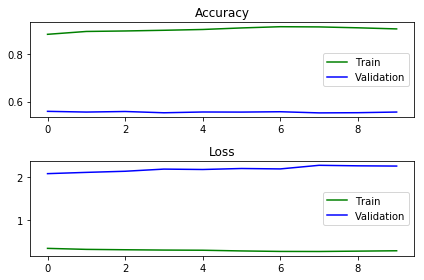

In [75]:
# plot loss and accuracy
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

#### Переобучения не наблюдается, о чем говорит плавный рост значения accuracy

# Результаты

#### Для каждой сети было подобрано оптимальное количество эпох и итераций.

#### Наилучшим образом зарекомендовала себя сеть LSTM, с точностью 0.99, а наихудшим - GRU, с точностью 0,72. 

#### В целом точность у шведского языка значительно выше, чем у каталонского